In [1]:
## ND2 > portable movie viewer 

# Cyna Shirazinejad
# 6/19/20
# This script will: 
#           - detect new movies in this parent folder "imaging_data" in Google Drive (coming)
#           - extract dimensions (x,y,z,t,channels) (complete)
#           - create a napari movie (in progress)

# capabilities needed:
# - auto thresholding
# - auto-segmentation (once we establish: organelles we'll be working with, expression levels, cell types, etc.)
# - auto-tracking of puncta (CME), blobs (organelles) that is then overlaid on images
# - text annotation: scale bar, channel names (auto-extracted from image title), markers, imaging settings (exposure, frame rate, intensity), conditions, timestamp (minute and seconds)

# pulse chase/stimulation: digital toggle indicating where 
# - photobleaching correction (probably exponential fit to start with)
# - extension/generalization to other data formats (TIFFS), Hd5



# combination of dimensions (t=time, c= channels, z= slices, x, y) this program can handle (granted they are ND2 to begin with):

# option #1 - 2d: t=1, c=1
# option #2 - 2d: t=1, c>1
# option #3 - 2d: t>1, c=1
# option #4 - 2d: t>1, c>1
# option #5 - 3d: t=1, c=1
# option #6 - 3d: t=1, c>1
# option #7 - 3d: t>1, c=1
# option #8 - 3d: t>1, c>1


In [2]:
# top priority for Max et al:
# - add time-stamp
# 

In [3]:
# not necessary unless running vm
# !source ~/.bash_profile


In [11]:
# import all necessary Python libraries

# configure the Jupyter Notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
%gui qt

import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + '/visualization_python_scripts_cyna'))
import pickle
import napari 
import imageio
import numpy as np
from os import listdir
from os.path import isfile, join
from ipywidgets import interact, interactive, fixed, interact_manual # for interactive widgets
from naparimovie import Movie
import dask.array as da
import dask
import tifffile
import subprocess
import scipy as sp
import scipy.optimize
from naparimovie_wrappers import MovieBuilder
from skimage.io import imread
from dask import delayed
import dask.array as da
from glob import glob
from PIL import Image
from nd2reader import ND2Reader

# enable widget plugins (necessary for this library)
!jupyter nbextension enable --py widgetsnbextension

# import custom Python modules
from visualization_nd2 import return_widgets_for_display, make_movie
from dask_to_napari import (convert_tiffs_to_dask_arrays, 
                            view_one_channel, 
                            view_one_time_one_channel,
                            view_specified_channels_one_time)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [9]:
# different file options (local to Cyna's computer)

#nsp34,ap2,arcp3
nsp34_ap2_arcp3_20200715='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_017.nd2'

# option with quick bleaching:
quick_bleaching_example = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61003.nd2'


# option 1
single_xy='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200619_nsp3-4GFP_sirActin/Captured Confocal 488.nd2'

# option 2
# NEEDED

#option 3
sec61_4_2d_time = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61004.nd2'

#option 3
sec61_5_2d_time = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61005.nd2'

#option 3
sec61_6_2d_time = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61006.nd2'

#option 3
sec61_7_2d_time = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61007.nd2'

# option 4
two_d_time_channels = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200615_nsp3-4-GFP_sirActin_CK666/1_RFP-CAAX-sirActin_25nM_18h/1_CAAX-RFP-sirActin25nm-18h_2s_5min_002.nd2'

# option 4
two_d_time_3_channels = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200615_nsp3-4-GFP_sirActin_CK666/3_Nsp-4GFP_RFP-CAAX_sirActin_25nM_18h/3-Nsp3-4GFP-CAAX-RFP_sirActin-25nM_3s_20min_007.nd2'

# option 4
matt_single_z = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200615_nsp3-4-GFP_sirActin_CK666/1_RFP-CAAX-sirActin_25nM_18h/1_CAAX-RFP-sirActin25nm-18h_2s_5min_002.nd2'

#option 5
sec61_0_3d_volume = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61.nd2'

#option 5
sec61_1_3d_volume = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61001.nd2'

#option 5
sec61_2_3d_volume = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61002.nd2'

# option 6
three_d_channels = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200615_nsp3-4-GFP_sirActin_CK666/1_RFP-CAAX-sirActin_25nM_18h/1_CAAX-RFP-sirActin25nm-18h_zseries_001.nd2'

# option 6
three_d_3_channels = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200615_nsp3-4-GFP_sirActin_CK666/3_Nsp-4GFP_RFP-CAAX_sirActin_25nM_18h/3-Nsp3-4GFP-CAAX-RFP_sirActin-25nM_zseries_005.nd2'

#option 7
sec61_3_3d_volume_time = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200629_Sec61/Sec61/Sec61003.nd2'

# option 8
matt_movie = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/cyna_pilot/20200619_nsp3-4GFP_sirActin/well1-Nsp3-4GFP-CAAX-RFP_sirActin-100nM.nd2'

# option 8
max_file = '/Users/cynashirazinejad/Downloads/bead_example_4.4.3M1001.nd2'

# mixed GFP cells from 7/28
FOV_7 = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200728_iPSClines/mixedGFP/con_pax_zo1_laminsec61_007.nd2'
FOV_4 = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200728_iPSClines/mixedGFP/con_pax_zo1_laminsec61_004.nd2'

# matt request the following to be prepared for group meeting 
FOV_1 = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200728_iPSClines/mixedGFP/for further processing - cyna/con_pax_zo1_laminsec61_001.nd2'
FOV_7 = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200728_iPSClines/mixedGFP/for further processing - cyna/con_pax_zo1_laminsec61_007.nd2'
# option 6
sec61_laminb1_nsp_3_nsp_4_z_stack = '/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200703_nsp3-4 transfection/Sec61-lamin-nsp3-4/Sec61-GFP_laminRFP_Nsp3-4Transfection_013.nd2'

# for group meeting 8/4/20
Sec61_GFP_laminRFP_noTransfection_001='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200703_nsp3-4 transfection/Sec61-lamin/Sec61-GFP_laminRFP_noTransfection_001.nd2'
Sec61_GFP_laminRFP_noTransfection_002='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200703_nsp3-4 transfection/Sec61-lamin/Sec61-GFP_laminRFP_noTransfection_002.nd2'

Sec61_GFP_laminRFP_Nsp3Transfection_001='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200703_nsp3-4 transfection/Sec61-lamin-nsp3/Sec61-GFP_laminRFP_Nsp3Transfection_001.nd2'
Sec61_GFP_laminRFP_Nsp3Transfection_002='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200703_nsp3-4 transfection/Sec61-lamin-nsp3/Sec61-GFP_laminRFP_Nsp3Transfection_002.nd2'

Sec61_GFP_laminRFP_Nsp3_4Transfection_007='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200703_nsp3-4 transfection/Sec61-lamin-nsp3-4/Sec61-GFP_laminRFP_Nsp3-4Transfection_007.nd2'
Sec61_GFP_laminRFP_Nsp3_4Transfection_010='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200703_nsp3-4 transfection/Sec61-lamin-nsp3-4/Sec61-GFP_laminRFP_Nsp3-4Transfection_010.nd2'

ap2arpc3_Nsp3_Nsp4_008='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_008.nd2'
ap2arpc3_Nsp3_Nsp4_009='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_009.nd2'
ap2arpc3_Nsp3_Nsp4_010='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_010.nd2'
ap2arpc3_Nsp3_Nsp4_013='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_013.nd2'
ap2arpc3_Nsp3_Nsp4_014='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_014.nd2'
ap2arpc3_Nsp3_Nsp4_015='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_015.nd2'
ap2arpc3_Nsp3_Nsp4_016='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_016.nd2'
ap2arpc3_Nsp3_Nsp4_017='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_017.nd2'


well2_Nsp3_4GFP_CAAX_RFP_sirActin_100nM_z_004='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200619_nsp3-4GFP_sirActin/well2-Nsp3-4GFP-CAAX-RFP_sirActin-100nM-z-004.nd2'
well2_Nsp3_4GFP_CAAX_RFP_sirActin_100nM_z_005='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200619_nsp3-4GFP_sirActin/well2-Nsp3-4GFP-CAAX-RFP_sirActin-100nM-z-005.nd2'
well2_Nsp3_4GFP_CAAX_RFP_sirActin_100nM_z_006='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200619_nsp3-4GFP_sirActin/well2-Nsp3-4GFP-CAAX-RFP_sirActin-100nM-z-006.nd2'
well2_Nsp3_4GFP_CAAX_RFP_sirActin_100nM_z_007='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200619_nsp3-4GFP_sirActin/well2-Nsp3-4GFP-CAAX-RFP_sirActin-100nM-z-007.nd2'

ap2arcp3nsp34_008='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_008.nd2'
ap2arcp3nsp34_009='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_009.nd2'
ap2arcp3nsp34_010='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_010.nd2'
ap2arcp3nsp34_013='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_013.nd2'
ap2arcp3nsp34_014='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_014.nd2'
ap2arcp3nsp34_015='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_015.nd2'
ap2arcp3nsp34_016='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_016.nd2'
ap2arcp3nsp34_017='/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/20200715_ap2_arpc3/nsp3+Nsp4/Nsp3+Nsp4_017.nd2'

In [14]:
# Meiyan's data:
ap2dynm2arcp3='/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/TIRF movies/200722_ADA3/ADA3_002.nd2'
ap2dynm2='/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/TIRF movies/200715_AD/AD_008.nd2'

In [15]:
# set the path for the file to process
file_to_process=ap2dynm2

In [18]:
ND2Reader(file_to_process).metadata

{'height': 512,
 'width': 512,
 'date': datetime.datetime(2020, 7, 15, 17, 10, 2),
 'fields_of_view': [0],
 'frames': range(0, 241),
 'z_levels': range(0, 241),
 'z_coordinates': [2558.46,
  2558.46,
  2558.44,
  2558.44,
  2558.44,
  2558.44,
  2558.44,
  2558.44,
  2558.42,
  2558.4,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.38,
  2558.34,
  2558.34,
  2558.32,
  2558.34,
  2558.32,
  2558.32,
  2558.32,
  2558.32,
  2558.34,
  2558.32,
  2558.32,
  2558.32,
  2558.32,
  2558.32,
  2558.3,
  2558.3,
  2558.3,
  2558.32,
  2558.32,
  2558.32,
  2558.32,
  2558.32,
  2558.32,
  2558.3,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.26,
  2558.26,
  2558.26,
  2558.26,
  2558.28,
  2558.28,
  2558.28,
  2558.26,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  2558.28,
  

In [7]:
# build the necessary widgets for the visualization tools

# use the following entry boxes and sliders to set the percentile of intensities in each available channel 
# to set the lower and upper cut-offs in percentiles allowed for display
# these are set to 0 and 100, respectively
num_channels, channels_to_view, channels_thresholded, percentile_ranges, all_percentiles_entrybox_lower_upper, threshold_options, image_dimensionality_array, axes_available, image_frames, display_widget, make_napari_movie=return_widgets_for_display(file_to_process)

for i in range(num_channels*2):
    display(all_percentiles_entrybox_lower_upper[i], percentile_ranges[i])

The file being processed is: /Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/TIRF movies/200722_ADA3/ADA3_002.nd2

The coordinates available in this file are: dict_keys(['x', 'y', 'c', 't', 'z'])

dict_keys(['x', 'y', 'c', 't', 'z'])
The number of x positions in each frame of the movie: 512
The number of y positions in each frame of the movie: 512
The number of channels in the movie: 3
The number of time points in the movie: 241
The number of z positions in each frame of the movie: 241
The dimensionality array of this file is: [241   3 241 512 512]
xyctz


FloatText(value=0.0, description='ch0 lower:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=0.0, continuous_update=False, description='percentile ch0 lower:', readout_format='.1f', sty…

FloatText(value=100.0, description='ch0 upper:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=100.0, continuous_update=False, description='percentile ch0 upper:', readout_format='.1f', s…

FloatText(value=0.0, description='ch1 lower:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=0.0, continuous_update=False, description='percentile ch1 lower:', readout_format='.1f', sty…

FloatText(value=100.0, description='ch1 upper:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=100.0, continuous_update=False, description='percentile ch1 upper:', readout_format='.1f', s…

FloatText(value=0.0, description='ch2 lower:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=0.0, continuous_update=False, description='percentile ch2 lower:', readout_format='.1f', sty…

FloatText(value=100.0, description='ch2 upper:', style=DescriptionStyle(description_width='initial'))

FloatSlider(value=100.0, continuous_update=False, description='percentile ch2 upper:', readout_format='.1f', s…

In [8]:
# create a napari viewer that is linked to a movie "state" output for movie generation
output = interactive(
            make_movie,
            {'manual': True},
            channels_to_display=channels_to_view,
            channels_to_threshold=channels_thresholded,
            threshold_methods=threshold_options,
            percentile_values=fixed(all_percentiles_entrybox_lower_upper),
            display_on=display_widget,
            file_to_process=fixed(file_to_process),
            image_dimensionality_array=fixed(image_dimensionality_array),
            axes_available=fixed(axes_available),
            image_frames=fixed(image_frames),
            make_naparimovie=make_napari_movie
           )

In [9]:
display(output) # display the napari viewer widgets and display tools
# select the channels to view (hold control/command to highlight multiple lines)
# select the channels to threshold; if a channel is selected for thresholding, a threshold method must be specified
# chose between no threshold, single-Otsu, and percentile

interactive(children=(SelectMultiple(description='view channels', options=('0', '1', '2'), value=()), SelectMu…

In [70]:
# if make naparimovie is checked, check if this global variable is carried over from the scripts
# this "movie" object is what naparimovie will render into a movie
# this cell must be run after every new run of display(output) so the most up-to-date napari viewer is used
movie = output.result

In [48]:
movie

In [16]:
# i sets a unique string name for the movie script
i=1

In [103]:
# for 1 channels, many time, 1 z stack
# # # %%capture
# number of channels in movie to generate script for
number_of_channels = 1
movie_text_command="visualization_scripts_new/movie_script"+str(i)+".txt"
# the granularity of angled rotations in function calls
# increase for smoothness (will take longer to render)
# decrease for testing script generations
# number_frames_per_unit_rotation = 5
# unit_rotation_degrees=15



# initialize the first frame in the naparimovie
# can be greater than 0 if you want a pause at the beginning
# the first "camera" frame of the naparimovie will start as the current
# state of the napari window. therefore, all contrast settings and visualization tweaks
# can be made in napari before starting the gif generation follow script generation

frame_start = 0

movie_current = MovieBuilder()

movie_current.shift_time(40,90)

# you can optionally get the frame of the movie for the next state as a return from any operation
# fim=movie_current.make_all_layers_invisible(2)

# you can manually set the frame in the movie for an increased duration
# movie_current._frame_in_movie = 20



# movie_current.make_one_layer_visible(0)


# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,3,unit_rotation_degrees,MovieBuilder.x_axis)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,24,unit_rotation_degrees,MovieBuilder.z_axis)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,21,unit_rotation_degrees,MovieBuilder.x_axis)
# movie_current.wait(30)
# movie_current.make_one_layer_invisible(0)

# movie_current.make_one_layer_visible(1)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,3,unit_rotation_degrees,MovieBuilder.x_axis)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,24,unit_rotation_degrees,MovieBuilder.z_axis)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,21,unit_rotation_degrees,MovieBuilder.x_axis)
# movie_current.wait(30)
# movie_current.make_one_layer_invisible(1)

# movie_current.make_one_layer_visible(0)
# movie_current.make_one_layer_visible(1)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,3,unit_rotation_degrees,MovieBuilder.x_axis)
# movie_current.wait(30)
# movie_current.rotate(number_frames_per_unit_rotation,24,unit_rotation_degrees,MovieBuilder.z_axis)
# movie_current.wait(30)


# movie_current.zoom(20,0.5)
# movie_current.wait(30)
# movie_current.zoom(20,2)

# make a movie script
movie_current.build_movie('visualization_scripts_new/movie_script'+str(i)+'.txt')


# make a new text file for the next run of this cell
i+=1

In [18]:
# for 3 channels, 1 time, z stack
# # # %%capture
# number of channels in movie to generate script for
number_of_channels = 3
movie_text_command="visualization_scripts_new/movie_script"+str(i)+".txt"
# the granularity of angled rotations in function calls
# increase for smoothness (will take longer to render)
# decrease for testing script generations


 
number_frames_per_unit_rotation = 5
unit_rotation_degrees=15



# initialize the first frame in the naparimovie
# can be greater than 0 if you want a pause at the beginning
# the first "camera" frame of the naparimovie will start as the current
# state of the napari window. therefore, all contrast settings and visualization tweaks
# can be made in napari before starting the gif generation follow script generation

frame_start = 0

movie_current = MovieBuilder()


# you can optionally get the frame of the movie for the next state as a return from any operation
fim=movie_current.make_all_layers_invisible(2)

# you can manually set the frame in the movie for an increased duration
# movie_current._frame_in_movie = 20

movie_current.make_one_layer_visible(0)
movie_current.wait(30)
# for example, if you want to rotate 45 degrees, you would do 3 "unit rotations" since each unit rotation is 15 degrees
# each unit of rotation will be 5 frames, as set by 'number_frames_per_unit_rotation' above
movie_current.rotate(number_frames_per_unit_rotation,3,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,24,unit_rotation_degrees,MovieBuilder.z_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,21,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.make_one_layer_invisible(0)

movie_current.make_one_layer_visible(1)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,3,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,24,unit_rotation_degrees,MovieBuilder.z_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,21,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.make_one_layer_invisible(1)

movie_current.make_one_layer_visible(0)
movie_current.make_one_layer_visible(1)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,3,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,24,unit_rotation_degrees,MovieBuilder.z_axis)
movie_current.wait(30)

# zoom in for 20 frames and zoom out by a factor of 2 (1/0.5)
movie_current.zoom(20,0.5)
movie_current.wait(30)
movie_current.zoom(20,2)

# make a movie script
movie_current.build_movie('visualization_scripts_new/movie_script'+str(i)+'.txt')


# make a new text file for the next run of this cell
i+=1

In [ ]:
movie_current = MovieBuilder()
movie_current.make_one_layer_visible(0)
movie_current.make_one_layer_visible(1)
movie_current.wait(30)
movie_current.rotate(30,3,20,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.rotate(30,24,20,MovieBuilder.z_axis)
movie_current.wait(30)


In [114]:
i=5

In [115]:
# for 3 channels, 1 time, z stack
# # # %%capture
# number of channels in movie to generate script for
number_of_channels = 3
movie_text_command="visualization_scripts_new/movie_script"+str(i)+".txt"
# the granularity of angled rotations in function calls
# increase for smoothness (will take longer to render)
# decrease for testing script generations
number_frames_per_unit_rotation = 5
unit_rotation_degrees=15



# initialize the first frame in the naparimovie
# can be greater than 0 if you want a pause at the beginning
# the first "camera" frame of the naparimovie will start as the current
# state of the napari window. therefore, all contrast settings and visualization tweaks
# can be made in napari before starting the gif generation follow script generation

frame_start = 0

movie_current = MovieBuilder()


# you can optionally get the frame of the movie for the next state as a return from any operation
# fim=movie_current.make_all_layers_invisible(2)

# you can manually set the frame in the movie for an increased duration
# movie_current._frame_in_movie = 20

# movie_current.make_one_layer_visible(0)
movie_current.make_one_layer_visible(0)
movie_current.wait(50)
movie_current.make_one_layer_visible(1)
movie_current.wait(50)
movie_current.make_one_layer_visible(2)
movie_current.wait(50)

movie_current.rotate(number_frames_per_unit_rotation,2,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation*2,24,unit_rotation_degrees,MovieBuilder.z_axis)
movie_current.wait(30)
movie_current.rotate(number_frames_per_unit_rotation,22,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)


# movie_current.make_one_layer_invisible(1)

# make a movie script
movie_current.build_movie('visualization_scripts_new/movie_script'+str(i)+'.txt')


In [50]:
i=6

In [58]:
# for 3 channels, 1 time, z stack
# # # %%capture
# number of channels in movie to generate script for
number_of_channels = 3
movie_text_command="visualization_scripts_new/movie_script"+str(i)+".txt"
# the granularity of angled rotations in function calls
# increase for smoothness (will take longer to render)
# decrease for testing script generations
number_frames_per_unit_rotation = 5
unit_rotation_degrees=15



# initialize the first frame in the naparimovie
# can be greater than 0 if you want a pause at the beginning
# the first "camera" frame of the naparimovie will start as the current
# state of the napari window. therefore, all contrast settings and visualization tweaks
# can be made in napari before starting the gif generation follow script generation

frame_start = 0

movie_current = MovieBuilder()


# you can optionally get the frame of the movie for the next state as a return from any operation
# fim=movie_current.make_all_layers_invisible(2)

# you can manually set the frame in the movie for an increased duration
# movie_current._frame_in_movie = 20

# movie_current.make_one_layer_visible(0)
frame_in_movie = movie_current.make_one_layer_visible(0)
movie_current.wait(50)
movie_current.make_one_layer_visible(1)
movie_current.wait(50)
movie_current.make_one_layer_visible(2)
movie_current.wait(50)

movie_current.rotate(number_frames_per_unit_rotation,2,unit_rotation_degrees,MovieBuilder.x_axis)
movie_current.wait(30)
movie_current.shift_time(50,10)
movie_current.rotate(number_frames_per_unit_rotation*2,24,unit_rotation_degrees,MovieBuilder.z_axis)



# movie_current.make_one_layer_invisible(1)

# make a movie script
movie_current.build_movie('visualization_scripts_new/movie_script'+str(i)+'.txt')


In [59]:
# before running make_gif() from naparimovie, ensure that the napari viewer is set correctly:
# the initial orientation of the channels, rotation orientation, zoom, contrasts, opacities, etc.
# the current state before make_gif() is called is what the rendered movie will use going forward for
# each frame of the movie

In [60]:
i=6

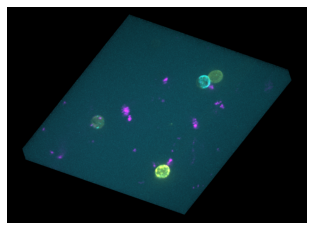

In [61]:
# create a series of naparimovie interpretable commands for generating a movie
movie.create_state_dict_from_script('visualization_scripts_new/movie_script'+str(i)+'.txt')
# generate the mp4 movie with the set fps and resolution
# movie.make_gif('/Volumes/GoogleDrive/Shared drives/drubin-barnes-lab_drive/project_overviews/coronavirus_research/imaging_data/data for cyna to filter for group meeting on 8:4:20/all_movies_made_by_cyna/20200703_nsp3-4 transfection/Sec61-lamin/Sec61-GFP_laminRFP_noTransfection_002'+'.gif')
movie.make_movie(name='max_movie.mp4',fps=10, resolution = 1000)

In [ ]:
def func_Example()

In [15]:
test_array = np.array([1,2,3,4])

In [16]:
test_array.argmax()

3

In [17]:
np.multiply(test_array,3)

array([ 3,  6,  9, 12])